In [1]:
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
from gym import wrappers

#### Create Lunar lander environment using gym

In [2]:
env = gym.make("LunarLander-v2")
number_of_actions = env.action_space.n
print("Number of elements in state space vector : ", env.observation_space.shape[0])
print("Number of actions there : ", env.action_space.n)

Number of elements in state space vector :  8
Number of actions there :  4


#### We can consider that the Lunar Lander environment as solved when the average reward returns 200 over 100 iterations.

#### Initialize constant variables

In [3]:
# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()
reward_threshold = 200
# max number of iterations in training the model
max_episodes = 10000
max_steps_per_episode = 1000
min_episodes_criterion = 100

#### We have implemented actor-critic in the ActorCrtic/main.py

In [4]:
# Import and create Actor critic agent
from main import Agent
agent = Agent(env=env, gamma=0.99, learning_rate=0.01, num_hidden_units = 128)

2021-12-17 13:26:06.841502: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-17 13:26:06.841753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def train_model(plot_results=True):
    episodes_reward = []
    average_rewards = []
    reward_count = 0
    with tqdm.trange(max_episodes) as t:
        for i in t:
            initial_state = tf.constant(env.reset(), dtype=tf.float32)
            episode_reward = int(agent.train_step(initial_state))

            episodes_reward.append(episode_reward)
            running_reward = statistics.mean(episodes_reward)
            average_reward = 0
            if len(episodes_reward) > 100:
                average_reward = np.mean(episodes_reward[-100:])
                average_rewards.append(average_reward)

            t.set_description(f'Episode {i}')
            t.set_postfix(
                episode_reward=episode_reward, average_reward=average_reward)

            # Show average episode reward every 10 episodes
            if i % 10 == 0:
                pass  # print(f'Episode {i}: average reward: {avg_reward}')

            if average_reward >=200:
                reward_count += 1
            else:
                reward_count = 0

            if average_reward > reward_threshold and reward_count >= 200:
                break

    agent.model.save("actor_crtic_model")
    print(f'\nSolved at episode {i}: average reward: {average_reward:.2f}!')
    if plot_results:
        plt.plot(episodes_reward, label="episode reward")
        plt.plot(average_rewards, label="average reward")
        plt.title("Actor-critic model")
        plt.legend()


In [6]:
def test(env: gym.Env, model: tf.keras.Model, max_steps: int): 
    
    scores, episodes, avg_scores, obj = [], [], [], []
    goal = 200
    score = 0.0
    for i in range(max_steps):
        state = tf.constant(env.reset(), dtype=tf.float32)
        done = False
        episode_score = 0.0
        while not done:
            env.render()
            state = tf.expand_dims(state, 0)
            action_probs, _ = model(state)
            action = np.argmax(np.squeeze(action_probs))

            state, reward, done, _ = env.step(action)
            state = tf.constant(state, dtype=tf.float32)
            episode_score += reward
            
            # action = self.policy(state)
            # new_state, reward, done, _ = env.step(action)
            # episode_score += reward
            # state = new_state
        score += episode_score
        print(episode_score)
        scores.append(episode_score)

    return

#### For training the actor critic model set `train=True` in the below cell.


In [7]:
train = False
if train:
    train_model()
else:
    env = gym.make("LunarLander-v2")
    env.reset()
    # env = wrappers.Monitor(env, "./actor_critic_results", force=True)
    model = tf.keras.models.load_model("actor_crtic_model")
    test(env, model, 10) 

2021-12-17 13:25:03.706 python[28587:3944095] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8f61d92b90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-12-17 13:25:03.706 python[28587:3944095] Warning: Expected min height of view: (<NSButton: 0x7f8f659bebb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-12-17 13:25:03.709 python[28587:3944095] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8f659bc000>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-12-17 13:25:03.711 python[28587:3944095] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7f8f659bf690>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-12-17 13:25:03.949261:

294.1650590716293
181.3693998782085
253.6587799500441
279.975544248666
226.73489528681478
240.21058686421006
251.74129284643098
229.92195790155617
226.5739627545733
255.86494762246372


Episode 8849:  88%|█████████████████████████████████████████████████████████████████████▉         | 8849/10000 [18:24<02:23,  8.01it/s, average_reward=208, episode_reward=228]
2021-12-17 13:44:39.817400: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: actor_crtic_model/assets

Solved at episode 8849: average reward: 208.18!


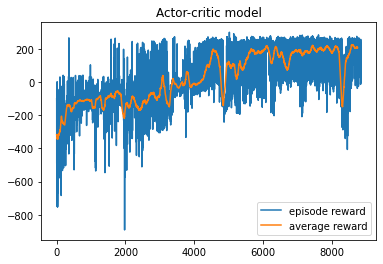

In [7]:
train_model()